In [1]:
import jax.numpy as jnp
import jax

In [2]:
def simple_graph(x):
    x = x + 2
    x = x**2
    x = x + 3
    y = x.mean()
    return y


inp = jnp.arange(3, dtype=jnp.float32)
print('Input', inp)
print('Output', simple_graph(inp))



Input [0. 1. 2.]
Output 12.666667


In [3]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

In [4]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradient', gradients)

Gradient [1.3333334 2.        2.6666667]


In [5]:
jax.make_jaxpr(grad_function)(inp)


{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[broadcast_dimensions=() shape=(3,)] h
    j:f32[3] = mul i e
  in (j,) }

In [6]:
from flax import linen as nn
import jax

In [7]:
class SimpleClassifier(nn.Module):
    num_hidden: int  # Number of hidden neurons
    num_outputs: int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x


In [8]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)

In [9]:
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [10]:
rng = jax.random.PRNGKey(4)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))  # Batch size 8, input size 2
# Initialize the model
params = model.init(init_rng, inp)
print(params)


FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-1.1033361 ,  0.25098908, -0.53021914,  0.7564092 ,
                          -0.95927685,  0.26463652, -1.3414687 ,  1.4645536 ],
                         [-0.33407998, -0.15410323, -0.24223687,  0.08547501,
                           0.14399047,  0.6298775 ,  0.00224211,  0.03256573]],            dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        Dense_1: {
            kernel: DeviceArray([[ 0.4590374 ],
                         [-0.5442363 ],
                         [-0.7325462 ],
                         [-0.5497943 ],
                         [-0.09890873],
                         [-0.02353257],
                         [ 0.78048426],
                         [ 0.4670926 ]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})


In [11]:
model.apply(params, inp)

DeviceArray([[ 0.68587136],
             [-0.8086996 ],
             [ 0.30942634],
             [ 0.7043244 ],
             [-0.83878434],
             [ 0.92531973],
             [-0.20422134],
             [-0.95156014]], dtype=float32)

In [12]:
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt

/home/jonathan/uni/thesis/code/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2,
                                   size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label


In [14]:
dataset = XORDataset(1000, 4)
dataset[0]


(array([0.09930219, 0.15300237], dtype=float32), 0)

In [15]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()


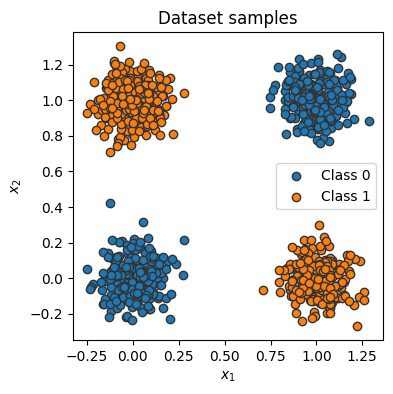

In [16]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [17]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


data_loader = data.DataLoader(dataset,
                              batch_size=8,
                              shuffle=True,
                              collate_fn=numpy_collate)


In [18]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)


Data inputs (8, 2) 
 [[ 1.0641762e+00  1.0217052e+00]
 [ 9.0898299e-01  9.6091235e-01]
 [ 4.1895825e-02  1.0718341e+00]
 [ 6.8609754e-04 -1.3996968e-01]
 [ 1.1805091e+00  1.1311644e+00]
 [ 1.5961856e-02 -1.4601113e-01]
 [-2.0679487e-02  1.2148883e+00]
 [ 9.7144198e-01  8.4028488e-01]]
Data labels (8,) 
 [0 0 1 0 0 0 1 0]


In [20]:
import optax
optimizer = optax.sgd(learning_rate=0.1)

In [21]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [23]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

In [24]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)


(DeviceArray(0.6114214, dtype=float32), DeviceArray(1., dtype=float32))

In [25]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(
        calculate_loss_acc,  # Function to calculate the loss
        argnums=1,  # Parameters are second argument of the function
        has_aux=True  # Function has additional outputs, here accuracy
    )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

In [26]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc


In [28]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    collate_fn=numpy_collate)


In [31]:
from tqdm import tqdm
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state


In [32]:
trained_model_state = train_model(model_state,
                                  train_data_loader,
                                  num_epochs=100)


100%|██████████| 100/100 [00:03<00:00, 26.11it/s]


In [34]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)


In [35]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a * b
               for a, b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [36]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


In [37]:
trained_model = model.bind(trained_model_state.params)

In [38]:
data_input, labels = next(iter(data_loader))
out = trained_model(
    data_input)  # No explicit parameter passing necessary anymore
out.shape


(8, 1)

/tmp/ipykernel_55712/1973199323.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


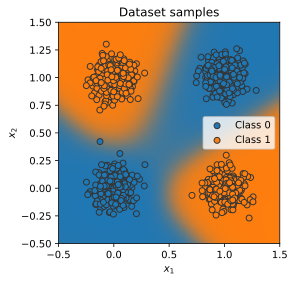

In [40]:
from matplotlib.colors import to_rgba
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg', 'pdf')
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4, 4), dpi=500)
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2,
                            indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None, None] + preds * c1[
        None, None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(
        output_image
    )  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig


_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()
